In [28]:
from __future__ import print_function
import numpy as np
from Ska.engarchive import fetch_eng as fetch
from Chandra.Time import DateTime
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime

### Star centroids, obsid just before the bad maneuver ###

In [29]:
fetch.data_source.set('maude')

In [30]:
start = '2017:090:17:00:00'
stop = '2017:090:18:27:00'

if 'dat' not in globals():
    dat = fetch.MSIDset(['aoacyan*', 'aoaczan*'], start, stop)

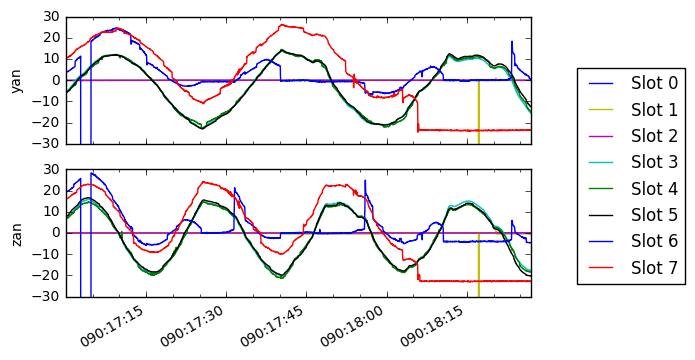

In [31]:
plt.close(1)
plt.figure(1)
plt.subplot(2, 1, 1)
for slot, color in zip(range(8), 'bymcgkbr'):
    msid = dat['aoacyan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color)
plt.ylim(-30, 30)
plt.ylabel("yan")

plt.subplot(2, 1, 2)
for slot, color in zip(range(8), 'bymcgkbr'):
    msid = dat['aoaczan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color,
                label='Slot {}'.format(slot))
plt.ylim(-30, 30)
plt.ylabel("zan")

plt.legend(loc=(1.1, 0.1))

plt.show()

### Change in OBC estimated attitude relative to the final BSH attitude###

<img src='bsh_2017_090_att.png'>

__ Important time stamps appear to be:__

In [32]:
t1 = '2017:090:18:55:40'
t2 = '2017:090:18:56:30'
t3 = '2017:090:18:58:35'
t4 = '2017:090:19:00:00'
t5 = '2017:090:19:02:00'
t6 = '2017:090:19:03:05'
t7 = '2017:090:19:07:00'

In [33]:
#dump2occ.py 2017_090_1147_090_2026_Dump_EM_54052N001.sto | splat.pl -vcdu 14952866

<img style="float: left" src='18_55_35.png' width='670'> KALM-> AQXN, t1 <br><br><br><br>
<img style="float: left" src='18_57_00.png' width='670'> GUID, between t2 and t3 <br>
Slot 2, star corrupted<br>
due to a hot pixel?<br>
<img style="float: left" src='18_57_56.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_17.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_26.png' width='670'> AQXN, between t3 and t4<br>
Slots 0-2 FIDs?<br>Slots 6-7 hot pixels<br>
<img style="float: left" src='18_58_30.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_42.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_51.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_54.png' width='670'><br><br><br><br><br>
<img style="float: left" src='18_58_57.png' width='670'><br><br><br><br><br>
<img style="float: left" src='19_00_02.png' width='670'>KALM, t4<br>
Slot 2, same star<br>
as between t2 and t3?<br><br>
<img style="float: left" src='19_02_10.png' width='670'>KALM -> BRIT, t5<br><br><br><br><br>
<img style="float: left" src='19_03_11.png' width='670'>BRIT -> KALM, t6<br>
Slot 6, corrupted<br>
due to a hot pixel
<img style="float: left" src='19_07_18.png' width='670'>
<img style="float: left" src='19_07_45.png' width='670'>
<img style="float: left" src='19_07_52.png' width='670'>
<img style="float: left" src='19_08_43.png' width='670'>

In [34]:
start = '2017:090:19:11:00'
stop = '2017:090:20:00:00'

dat_bsh = fetch.MSIDset(['aoacyan*', 'aoaczan*'], start, stop)

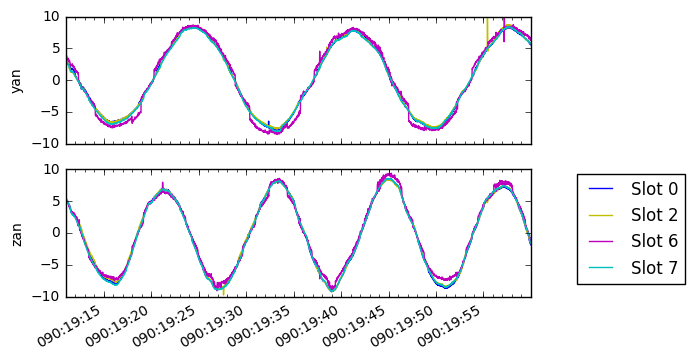

In [35]:
plt.close(1)
plt.figure(1)
plt.subplot(2, 1, 1)
for slot, color in zip([0, 2, 6, 7], 'bymc'):
    msid = dat_bsh['aoacyan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color)
plt.ylim(-10, 10)
plt.ylabel("yan")

plt.subplot(2, 1, 2)
for slot, color in zip([0, 2, 6, 7], 'bymc'):
    msid = dat_bsh['aoaczan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color,
                label='Slot {}'.format(slot))
plt.ylim(-10, 10)
plt.ylabel("zan")

plt.legend(loc=(1.1, 0.1))

plt.show()